<h3>Intraday Strategy Using GARCH Model.</h3>
<ul>
    <li>Using simulated daily data and intraday 5-min data.</li>
    <li>Load Daily and 5-minute data.</li>
    <li>Define funtion to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.</li>
    <li>Calculate predication premium and form a daily signla from it.</li>
    <li>Merge with intraday data and calculate intraday indicators to form the intraday signal.</li>
    <li>Generate the position entry and hold until the end of the day.</li>
    <li>Calculate final strategy returns.</li>
</ul>

<h3>1. Load Simulated Daily and Simulated 5-minute data.</h3>
<ul>
    <li>We are loading both datasets, set the indexes and calculate daily log returns.</li>
</ul>

In [88]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from arch import arch_model
import pandas as pd
import pandas_ta
import numpy as np
import os

# Define the path to the folder containing the data files.
# This path will be used to load CSV files containing daily and intraday data.
data_folder = '/Users/codymckeon/Library/Mobile Documents/com~apple~CloudDocs/ml_projects/unsupervised/intraday_garch_model/data'

# Load the simulated daily data from a CSV file into a pandas DataFrame.
# The CSV file is expected to contain columns like 'Date' and 'Adj Close'.
daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

# Convert the 'Date' column in the daily data to datetime format.
# This is essential for time-series analysis and setting the date as an index.
daily_df['Date']= pd.to_datetime(daily_df['Date'])

# Set the 'Date' column as the index of the DataFrame.
# This allows for easier time-series operations, such as resampling or filtering by date.
daily_df = daily_df.set_index('Date')

# Calculate the logarithmic returns based on the 'Adj Close' prices.
# The log returns are computed by taking the natural log of the adjusted close price and then differencing it.
# This is a common transformation used in financial analysis to analyze returns.
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()
# Drop the 'Unnamed: 7' column
daily_df.drop(columns=['Unnamed: 7'], inplace=True)

# Load the simulated intraday 5-minute data from a CSV file into a pandas DataFrame.
# The CSV file is expected to contain columns like 'datetime' and other relevant financial data.
intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

# Convert the 'datetime' column to datetime objects and extract the date
intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df['datetime']).dt.date

# Drop the 'Unnamed: 6' column
intraday_5min_df.drop(columns=['Unnamed: 6'], inplace=True)


# Convert the 'datetime' column in the intraday data to datetime format.
# This ensures that the timestamp is correctly interpreted for time-series analysis.
intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

# Set the 'datetime' column as the index of the DataFrame.
# This allows for easier time-series operations, such as filtering or aggregating data by time intervals.
intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df['date'])

intraday_5min_df
# Extract only the date component from the index of the intraday data.
# This could be useful for aligning intraday data with daily data or performing date-based groupings.
# intraday_5min_df.index.date

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


<h3>2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window. </h3>
<ul>
    <li>We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.</li>
</ul>

In [89]:
# To create a fit to the GARCH model. Autoregressive orders. BruteForce fit 16 models combination 1,2,3,4 16 models extract Mean Squared error and Bayseian Information Criteria.
daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020-01-01':].copy()


def predict_volatility(x):
    #Rescale the data
    rescaled_x = x * 1000

    
    best_model = arch_model(y=rescaled_x,
                            p=1,
                            q=3).fit(update_freq=5, disp='off')

    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]

    print(x.index[-1])


    return variance_forecast


daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x)) 


daily_df

2020-06-28 00:00:00
2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-17 00:00:00
2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-25 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00
2020-08-08 00:00:00
2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00


,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions
Date,,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,0.000914,0.001125,NaN
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,-0.030273,0.001127,NaN
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,0.050172,0.001139,NaN
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,0.008915,0.001110,NaN
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,0.000089,0.001106,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,333.785597
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,292.268013
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,285.739872


<Axes: xlabel='Date'>

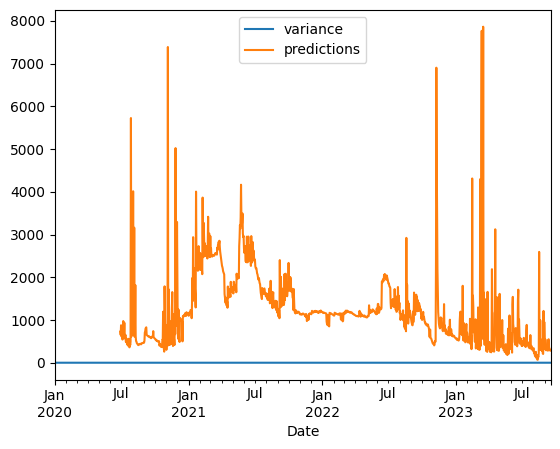

In [90]:
daily_df[['variance', 'predictions']].plot()

<h3>3. Calculate prediction premium and form a daily signal from it.</h3>
<ul>
    <li>We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.</li>
    <li>From this we are creating our daily signal.</li>
</ul>

In [91]:
daily_df['prediction_premium'] = (daily_df['predictions']- daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std']*1.5)
                                         else (-1 if (x['prediction_premium']< x['premium_std']*-1.5) else np.nan),
                                          axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()
daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,0.000914,0.001125,NaN,NaN,NaN,NaN
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,-0.030273,0.001127,NaN,NaN,NaN,NaN
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,0.050172,0.001139,NaN,NaN,NaN,NaN
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,0.008915,0.001110,NaN,NaN,NaN,NaN
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,0.000089,0.001106,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,333.785597,848252.153354,635122.004921,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,292.268013,759224.496190,628739.558426,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,285.739872,743214.665709,628734.381164,NaN


In [92]:
daily_df[daily_df['signal_daily']==1]

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2021-01-12,8879.089844,9142.131836,8174.494141,8480.740234,8480.740234,7.477328e+10,-0.047316,0.000961,1443.836158,1.501794e+06,1.118926e+06,1.0
2021-01-14,9331.277344,9991.601563,9217.140625,9796.832031,9796.832031,6.361599e+10,0.048922,0.001013,1653.480890,1.631621e+06,1.126182e+06,1.0
2021-01-16,9205.412109,9466.091797,8908.388672,9044.535156,9044.535156,5.770619e+10,-0.017732,0.001044,1994.741482,1.911175e+06,1.127873e+06,1.0
2021-01-17,9040.912109,9180.587891,8517.330078,8947.819336,8947.819336,5.235985e+10,-0.010751,0.001044,1656.112561,1.585853e+06,1.127142e+06,1.0
2021-01-22,7704.406250,8452.962891,7238.343262,8251.440430,8251.440430,7.720727e+10,0.068333,0.001194,2609.614700,2.185274e+06,1.136331e+06,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-07,6808.912598,6833.045410,6536.747070,6586.499512,6586.499512,1.953005e+10,-0.033325,0.000614,908.174737,1.479623e+06,1.285703e+06,1.0
2023-06-21,7077.827637,7684.332520,7070.852539,7506.824219,7506.824219,3.334676e+10,0.058274,0.000635,1709.142080,2.691212e+06,1.294719e+06,1.0
2023-06-22,7498.983887,7623.999512,7419.789551,7478.070313,7478.070313,2.065316e+10,-0.003838,0.000635,511.913181,8.057053e+05,1.294571e+06,1.0


<Axes: ylabel='Frequency'>

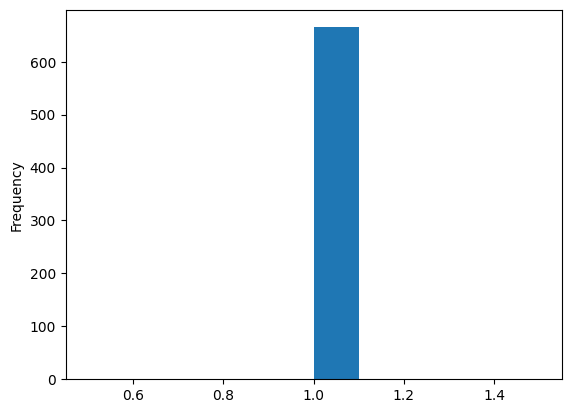

In [93]:
daily_df['signal_daily'].plot(kind="hist")

<h3>4. Merge with intraday data and calculate intraday indicators to form the intraday signal. </h3>
<ul>
    <li>Calculate all intraday indicators and intraday signal.</li>
</ul>

In [94]:
final_df = intraday_5min_df.reset_index()\
            .merge(daily_df['signal_daily'].reset_index(),
                   left_on='date',
                   right_on='Date').set_index('datetime')

final_df = final_df.drop(['date', 'Date'], axis=1)

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                           (x['close']>x['uband'])
                                            else (-1 if (x['rsi']<30)&
                                                        (x['close']<x['lband']) else np.nan),
                                                        axis=1)

final_df

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday
datetime,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,1.0,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,1.0,NaN,NaN,NaN,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,1.0,NaN,NaN,NaN,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,1.0,NaN,NaN,NaN,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN


<h3>5. Generate the position entry and hold until the end of the day.</h3>


In [84]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (-1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)
final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                            .transform(lambda x: x.ffill())

final_df['return'] = final_df['close'].pct_change() 

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))[['strategy_return']].sum()

<h3>6. Calculate final strategy returns. </h3>

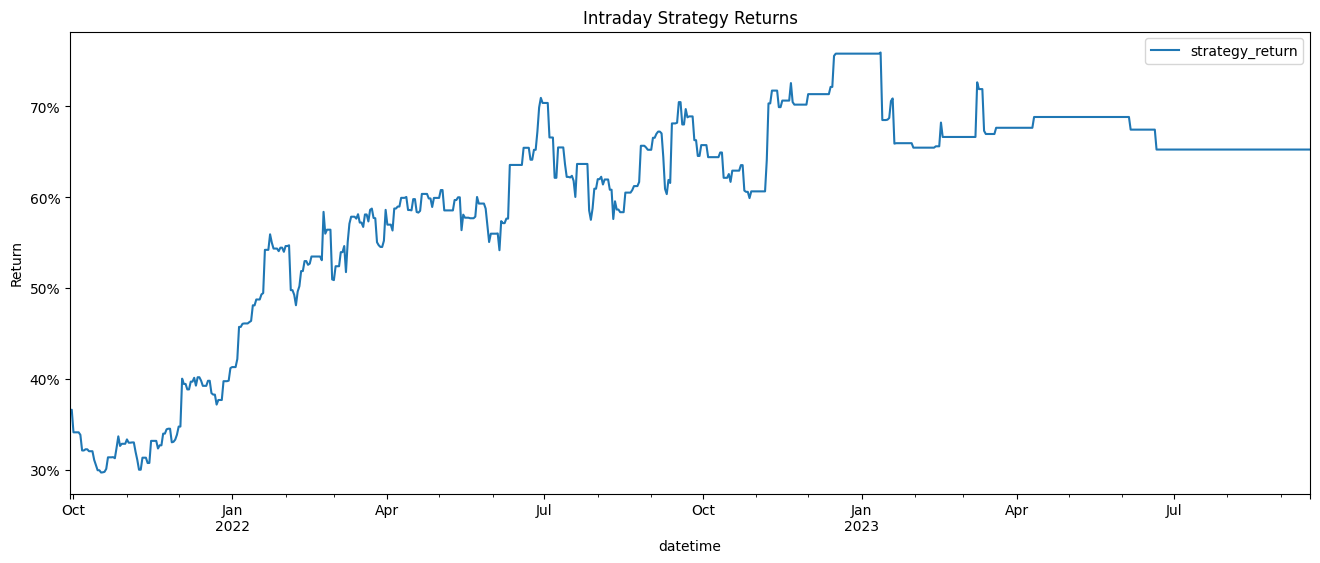

In [95]:
strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum().sub(1))

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()